# Blackjack

### Zadatak - nivo 3

Napravite igru simetrično na sledeći način: Umesto Igrača i Dilera, razgovaraćemo o Igraču 1 i Igraču 2.

Svaka igra se sastoji od dva kruga, u prvom krugu Igrač 1 igra prvi, a u drugom krugu Igrač 2 igra prvi.

Svaki krug je jedna igra blackjack-a sa po jednom kartom dodeljenom svakom igraču i jednom zajedničkom izvučenom kartom (tako da svaki igrač formira početni zbir iz dve karte, pri čemu je jedna karta deljena od strane oba igrača). Svaki igrač igra (bira "HIT" ili "HOLD") u svakom potezu. Ako jedan od igrača pređe 21, ili ako jedan od igrača izabere HOLD, drugi igrač nastavlja da izvlači karte dok i on/ona ne pređe 21 ili izabere ZADRŽI. Na kraju, igrač sa najvećim zbirom manjim od 21 dobija taj krug.

Po završetku kruga, svaki igrač dobija +1, 0, ili -1, zavisno od ishoda. Ukupan rezultat jedne igre je zbir ishoda oba kruga.


In [2]:
from enum import Enum
from dataclasses import dataclass, astuple
from typing import Callable
from random import random, randint
from copy import deepcopy

from tqdm import trange
from rich import print

import numpy as np
import matplotlib.pyplot as plt

class CardSuit(Enum):
    """An enumeration representing card suits."""
    
    DIAMONDS = 0
    CLUBS = 1
    HEARTS = 2
    SPADES = 3

    def __repr__(self):
        match self:
            case CardSuit.DIAMONDS:
                return "♦"
            case CardSuit.CLUBS:
                return "♣"
            case CardSuit.HEARTS:
                return "♥"
            case CardSuit.SPADES:
                return "♠"

class CardValue(Enum):
    """An enumeration representing card values."""

    ACE = 1
    TWO = 2
    THREE = 3
    FOUR = 4
    FIVE = 5
    SIX = 6
    SEVEN = 7
    EIGHT = 8
    NINE = 9
    TEN = 10
    JACK = 12
    DAME = 13
    KING = 14

    def __repr__(self):
        if self == CardValue.ACE:
            return "A"
        elif self.value >= 2 and self.value <= 10:
            return str(self.value)
        elif self == CardValue.JACK:
            return "J"
        elif self == CardValue.DAME:
            return "D"
        elif self == CardValue.KING:
            return "K"
        
@dataclass
class Card:
    """A playing card."""
    value: CardValue
    suit: CardSuit

    def __repr__(self):
        return f"{repr(self.value)}{repr(self.suit)}"

class CardDeck:
    """A deck of cards.

    The deck contains 52 playing cards, which are shuffled and drawn consecutively.
    Once all cards have been drawn, the deck reshuffles automatically.
    """

    def reshuffle(self):
        """Refill the deck with all playing cards and reshuffle it."""
        self.cards = self.multiplicity * [Card(value=v, suit=s) 
                                          for v in iter(CardValue) 
                                          for s in iter(CardSuit)]
        np.random.shuffle(self.cards) 

    def __init__(self, multiplicity=5):
        """Create a shuffled deck of cards.
        
        Args:
            multiplicity (int): The number of 52-card sets to put inside a deck.
        """
        self.multiplicity = multiplicity
        self.reshuffle()

    def draw(self):
        """Draw a card from the deck.

        Once drawn, the card is removed from the deck. Once there are no more cards inside,
        the deck will automatically refill and reshuffle.
        """
        if not self.cards:
            self.reshuffle()
        return self.cards.pop(0)

@dataclass
class State:
    """The state of a Blackjack game"""
    total: int
    has_ace: bool
    dealer_total: int

    def __hash__(self):
        return hash(astuple(self))

    def __repr__(self):
        return repr(astuple(self))

def update_total(total: int, has_ace: bool, card_value: CardValue) -> tuple[int, bool]:
    """Update (a portion of) the player state by taking account a newly drawn card.
    
    Given the information regarding the current player state (total and ACE info), and the
    value of a newly drawn card, updates the current player state (both total and ACE info).

    The updated total returned by this function can be bigger than 21.
    The function correctly tracks statuses of ACEs (i.e. it changes values of ACEs from
    11 to 1, when appropriate, in order for the total not to excede 21), however, if
    after this the total still remains bigger than 21 the function will simply return it
    as is.

    Args:
        total (int): player total
        has_ace (bool): indicates if the player has usable ACE
        card_value (CardValue): value of the newly drawn card

    Returns:
        int: updated player total
        bool: updated info indicating if the player has a usable ACE
    """
    if card_value == CardValue.ACE:
        if total + 11 <= 21:
            # We have an ACE and the total is less than 21.
            # We can keep the ACE as 11.
            # Notice that it was impossible that we had another ACE in posession
            # before (since in that case the total would surely be bigger than 21)
            return (total+11, True)
        else:
            # The total excedes 21, and we must count the ACE as 1.
            # It is possible we had another active ACE before, if so the
            # status of this old ACE does not change.
            return (total+1, has_ace)
    else:
        total += min(card_value.value, 10)
        if total > 21:
            # The player is potentially busted.
            if has_ace:
                # If we have an active ACE, we are saved.
                # The ACE value is reduced from 11 to 1 (and the total is reduced by 10).
                # However, the cost is that we no longer have an active ACE.
                total -= 10
                return (total, False)
            else:
                # We have not active ACE, so we cannote decrease the total
                return (total, has_ace)
        # The total is less than 21, we may return the state as is.
        return (total, has_ace)

def random_state() -> State:
    """Generate a random state."""
    total = randint(2, 21)
    if total>= 11:
        r = random()
        if r >= 0.5:
            has_ace = True
        else:
            has_ace = False
    else:
        has_ace = False
    dealer_value = randint(2, 11)
    return State(total, has_ace, dealer_value)

def all_states() -> list[State]:
    """Create a list of all possible Blackjack states."""
    states = []
    for total in range(2, 22):
        for dealer_value in range(2, 12):
            states.append(State(total, False, dealer_value))
            if total >= 11:
                states.append(State(total, True, dealer_value))
    return states

class Action(Enum):
    """Blackjack action."""
    HIT = 0
    HOLD = 1

    def __repr__(self):
        return "HIT" if self == Action.HIT else "HOLD"

def random_action() -> Action:
    """Return random action."""
    r = random()
    if r <= 0.5:
        return Action.HIT
    else:
        return Action.HOLD

Policy = Callable[[State], Action]
def random_policy(s: State) -> Action:
    return random_action()

def dealer_policy(s: State) -> Action:
    total, has_ace, _ = astuple(s)
    if total < 17:
        return Action.HIT
    else:
        return Action.HOLD
    
def get_init_state(state: State | str | None, deck: CardDeck) -> State:
    """Generate initial state."""
    if state is None:
        player_card = deck.draw()
        total, has_ace = update_total(0, False, player_card.value)
        dealer_card = deck.draw()
        dealer_value = min(dealer_card.value.value, 10)
        return State(total, has_ace, dealer_value)
    else:
        if isinstance(state, str):
            assert state == "random", f"Invalid init state specification: '{state}'"
            return random_state()
        else:
            return state

def get_init_action(action: Action | str | None, state: State, policy: Policy) -> Action:
    """Generate initial action."""
    if action is not None:
        if isinstance(action, str):
            assert action == "random", f"Ivalid init action specification: '{action}'"
            return random_action()
        else:
            return action
    else:
        return policy(state)

TurnLog = list[tuple[State, Action]]
ReportCallback = Callable[[str], None]

def play_turn(policy: Policy, 
              deck: CardDeck, 
              init_state: State | None = None,
              init_action: Action | None = None, 
              report_callback: ReportCallback | None = None) -> tuple[int | None, TurnLog]:
    """A single playing turn of an agent.

    Args:
        policy (Policy): decision policy used by the agent
        deck (CardDeck): deck of cards from which to draw
        init_state (State | None): initial state or `None` if the initial state
                                   is to be selected by drawing from the deck.
        init_action (Action | None): initial action or `None` if the initial action
                                     is to be selected according to the decision policy
        report_callback (ReportCallback | None): callback used to report progress
                                                 if `None`, the turn will be played silently

    Return:
        int | None: The final agent's total or `None` if the agent is busted
        TurnLog: sequence of states and actions observed during gameplay
    """
    report = lambda txt: report_callback and report_callback(txt)
    state = get_init_state(init_state, deck)
    action = get_init_action(init_action, state, policy)
    total, has_ace, dealer_value = astuple(state)
    report(f"[bold]initial state[/] {state}")
    report(f"initial total {total} with ACE {has_ace} => [bold]initial action[/] {action}")
    turn_log = [(state, action)]
    while action == Action.HIT:
        card = deck.draw()
        total, has_ace = update_total(total, has_ace, card.value)
        state = State(total, has_ace, dealer_value)
        if total > 21:
            # Since total is above 21, the state is not valid and should not
            # be logged!
            report(f"turned finished - [bold]BUSTED![/] card drawn {card} => total {total} with ACE {has_ace}")
            return None, turn_log
        else:
            action = policy(state)
            turn_log.append((state, action))
            report(f"card drawn {card} => total {total} with ACE {has_ace} => action chosen {action}")
    report(f"turn finished with final total {total}")
    return total, turn_log

Experience = tuple[State, Action, float]
def compute_gain(rewards: list[float], gamma: float) -> float:
    """
    Compute the total gain given the list of future rewards.
    
    Args:
        rewards (list[float]): List of future rewards.
        gamma: discount factor

    Return:
        float: The total gain
    """
    g = 0
    w = 1
    for r in rewards:
        g += w*r
        w *= gamma
    return g

def discounted_gains(rewards: list[float], gamma) -> list[float]:
    """
    Compute list of discounted gains, given a sequence of rewards.

    Args:
        rewards (list[float]): Sequence of rewards.
        gamma: discount factor

    Return:
        list[float]: sequence of gains
    """
    gains = [compute_gain(rewards[i:], gamma) for i in range(len(rewards))]
    return gains

def build_experience(turn_log: TurnLog, result: int, gamma) -> Experience:
    """
    Compute experience from the turn log (list of state-action pairs) and the final result.

    Args:
        turn_log (TurnLog): List of state-action pairs encountered during single gameplay
        result (int): Final result of the game.

    Return:
        Experience: List of state-action-gain triples corresponding to every state-action pair encountered during a game.
    """
    rewards = [0 for _ in turn_log]
    rewards[-1] = result
    gains = discounted_gains(rewards, gamma)
    exp = [(s, a, g) for (s, a), g in zip(turn_log, gains)]
    return exp

def play_game(policy: Policy, 
              deck: CardDeck, 
              init_state: State | str | None = None,
              init_action: Action | str | None = None,
              gamma : float = 1.0,
              game_report_callback: ReportCallback | None = None,
              player_report_callback: ReportCallback | None = None,
              dealer_report_callback: ReportCallback | None = None) -> tuple[int, Experience]:
    """A single game of Blackjack, played with the given policy.
    
    Args:
        policy (Policy): the decision policy to use during gameplay
        init_state (State | str | None): specification of the initial state, see `get_init_state`
        init_action (Action | str | None): specification of the initial action, see `get_init_action`
        gamma (float): discount factor
        game_report_callback (ReportCallback | None): report callback used for the events generated by the game "engine"
        player_report_callback (ReportCallback | None): report callback used for the player actions
        dealer_report_callback (ReportCallback | None): report callback used for the dealer actions

    Return:
        int: The result of the game: +1 for win, 0 for draw, -1 for loss
        Experience: experience accumulated during the game 
    """
    report = lambda txt: game_report_callback and game_report_callback(txt)
    state = get_init_state(init_state, deck)
    action = get_init_action(init_action, state, policy)
    player_total, turn_log = play_turn(policy, deck, init_state=state, init_action=action, report_callback=player_report_callback)
    if player_total is not None:
        dealer_card = CardValue(state.dealer_total) if state.dealer_total != 11 else CardValue.ACE
        dealer_total, dealer_has_ace = update_total(0, False, dealer_card)
        dealer_state = State(dealer_total, dealer_has_ace, 0)
        dealer_total, _ = play_turn(dealer_policy, deck, init_state=dealer_state, report_callback=dealer_report_callback)
        if dealer_total is not None:
            if player_total > dealer_total:
                result = +1
            elif player_total == dealer_total:
                result = 0
            else:
                result = -1
        else:
            result = +1
    else:
        result = -1
    exp = build_experience(turn_log, result, gamma)
    if result == 1:
        report("Player WINS")
    elif result == 0:
        report("Game DRAW")
    else:
        report("Player LOSES")
    return result, exp

player_report_callback = lambda txt: print(f"[bold yellow]PLAYER:[/] {txt}")
dealer_report_callback = lambda txt: print(f"[bold cyan]DEALER:[/] {txt}")
game_report_callback = lambda txt: print(f"[bold red]{txt}[/]")

callbacks = {
    "player_report_callback": player_report_callback,
    "dealer_report_callback": dealer_report_callback,
    "game_report_callback": game_report_callback
}

@dataclass
class PolicyTestingResult:
    games_no: int
    score: int
    wins: float
    draws: float
    losses: float

    def loss_per_game(self):
        """Average loss per game."""
        return self.score/self.games_no

    def __repr__(self):
        return f"total score={self.score}/{self.games_no} games ({self.loss_per_game():.4f} per game) :: W {self.wins*100:.2f}% | D {self.draws*100:.2f}% | L {self.losses*100:.2f}%"

def apply_policy(policy: Policy, deck: CardDeck, games_no=1000, gamma=1, random_init_state=False, random_init_action=False) -> tuple[PolicyTestingResult, Experience]:
    wins, losses, draws, score = 0, 0, 0, 0
    init_action = "random" if random_init_action else None
    init_state = "random" if random_init_state else None
    experience = []
    for k in range(games_no):
        res, exp = play_game(policy, deck, gamma=gamma, init_state=init_state, init_action=init_action)
        score += res
        experience.extend(exp)
        if res == 1:
            wins += 1
        elif res == 0:
            draws += 1
        else:
            losses += 1
    return PolicyTestingResult(games_no, score, wins/games_no, draws/games_no, losses/games_no), experience

QDict = dict[State, tuple[float, float]]

def create_greedy_policy(q_dict: QDict) -> Policy:
    """Create a greedy policy function based on the given Q-dictionary."""
    no_actions = len(list(Action))

    def policy(s: State):
        q_values = q_dict.get(s, None)
        if q_values is not None:
            assert len(q_values) == no_actions, f"Invalid Q-dict for state {s}."
            if any([v is None for v in q_values]):
                return random_policy(s)
            else: 
                ndx = np.argmax(q_values)
                return Action(ndx)
        else:
            return random_policy(s)
    
    return policy

GainsDict = dict[State, tuple[list[float], list[float]]]

def create_gains_dict(experience: Experience)-> GainsDict:
    """Create gains dict from the given experience."""
    gains_dict = dict()
    for s, a, g in experience:
        action_gains = gains_dict.get(s, ([], []))
        action_gains[a.value].append(g)
        gains_dict[s] = action_gains
    return gains_dict

def evaluate_Q(experience: Experience) -> QDict:
    """Evaluate Q-function based on the given experience."""
    gains_dict = create_gains_dict(experience)

    q_dict = dict()
    for s, (gains_HIT, gains_HOLD) in gains_dict.items():
        q_value_HIT = np.mean(gains_HIT) if gains_HIT else None
        q_value_HOLD = np.mean(gains_HOLD) if gains_HOLD else None
        q_dict[s] = (q_value_HIT, q_value_HOLD)
    return q_dict

def visualize_policy(policy):
    """Visualize the policy.

    The policy will be visualized using a colored greed.
    The horizontal axis will correspond to the player total and the vertical axis to the
    dealer's total.

    If a cell is colored in red, it means that the action is HIT, regardless of existence of usable ACE.
    If a cell is colored in blue, it means HOLD, regardless of existence of usable ACE.
    Green cells are those in which HIT will be played only if there is a usable ACE.
    Black cells are those in which HIT will be played only if there is no usable ACE.

    Since the last case (play HIT if there is no usable ACE, and HOLD otherwise) seems counterintutive,
    the color black is selected to distinguish it from other states.
    """
    player_values = list(range(2, 21))
    dealer_values = list(range(2, 12))
    board = np.ones(shape=(len(dealer_values), len(player_values), 3), dtype=np.uint8)
    for r, dv in enumerate(dealer_values):
        for c, pv in enumerate(player_values):
            if pv < 11:
                action_t = policy(State(pv, False, dv)) == Action.HIT
                if action_t:
                    board[r, c, :] = (255, 0, 0)
                else:
                    board[r, c, :] = (0, 0, 255)
            else:
                action_t = policy(State(pv, True, dv)) == Action.HIT
                action_f = policy(State(pv, False, dv)) == Action.HIT
                if action_t and action_f:
                    board[r, c, :] = (255, 0, 0)
                elif action_t and not action_f:
                    board[r, c, :] = (0, 255, 0)
                elif not action_t and not action_f:
                    board[r, c, :] = (0, 0, 255)
                else:
                    board[r, c, :] = (0, 0, 0)
    plt.imshow(board, extent=[2, 21, 12, 2])
    plt.xticks(np.arange(2.5, 21.5, 1), np.arange(2, 21, 1))
    plt.yticks(np.arange(2.5, 12.5, 1), np.arange(2, 12, 1))
    plt.xlabel("player total")
    plt.ylabel("dealer total")

def update_q_value(current: float, target: float, alpha: float) -> float:
    """Update the given current estimate given the new target.
    
    Args:
        current (float): existing estimate
        target (float): the given target
        alpha (float): learning rate

    Return:
        float: the new, updated estimate
    """
    if current is not None and target is not None:
        return current + alpha * (target - current)
    elif current is None:
        return target
    elif target is None:
        return current
    else:
        return None

def update_Q(q_dict: QDict, experience: Experience, alpha=0.1):
    """Update Q-function based on the given experience."""
    gains_dict = create_gains_dict(experience)

    for s, (gains_HIT, gains_HOLD) in gains_dict.items():
        target_value_HIT = np.mean(gains_HIT) if gains_HIT else None
        target_value_HOLD = np.mean(gains_HOLD) if gains_HOLD else None
        old_value_HIT, old_value_HOLD = q_dict.get(s, (None, None))
        q_value_HIT = update_q_value(old_value_HIT, target_value_HIT, alpha)
        q_value_HOLD = update_q_value(old_value_HOLD, target_value_HOLD, alpha)
        q_dict[s] = (q_value_HIT, q_value_HOLD)

    return q_dict

Iznad je profesorov kod. Ispod krece trening oba igraca prvo protiv dilera, a onda medjusobno.

In [3]:
# Igrac igra protiv dilera num_games broj puta
def pre_train_player(deck: CardDeck, num_games: int, alpha: float = 0.1, gamma: float = 0.9):
    q_dict = dict()
    results = []
    results_val = []
    best_val_loss = None
    q_dict_best = None
    alpha = 0.02
    for k in trange(100):
        policy = create_greedy_policy(q_dict)
        res, exp = apply_policy(policy, deck, num_games, gamma=0.5, random_init_action=True, random_init_state=True)
        res_val, _ = apply_policy(policy, deck, num_games)
        results.append(res.loss_per_game())
        results_val.append(res_val.loss_per_game())
        if not best_val_loss or best_val_loss <  res_val.loss_per_game():
            best_val_loss = res_val.loss_per_game()
            q_dict_best = deepcopy(q_dict)
        update_Q(q_dict, exp, alpha)
    plt.plot(results)
    plt.plot(results_val)
    plt.grid(True)

    best_policy = create_greedy_policy(q_dict_best)
    res, _ = apply_policy(best_policy, deck, 10000)
    print(res)

    visualize_policy(best_policy)
    return policy, q_dict

Pretraining Player 1:

100%|██████████| 100/100 [00:20<00:00,  4.97it/s]


total score=-881/10000 games (-0.0881 per game) :: W 41.69% | D 7.81% | L 50.50%

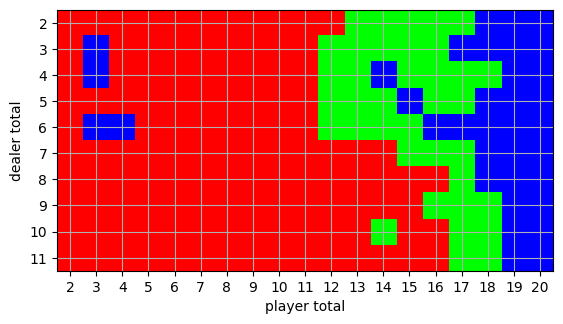

In [4]:
deck = CardDeck()
epochs_pretrain = 1500
q_dict_player1 = dict()
print("Pretraining Player 1:")
policy1, q_dict_player1 = pre_train_player(deck, num_games=epochs_pretrain)

Pretraining Player 2:

100%|██████████| 100/100 [00:20<00:00,  4.82it/s]


total score=-555/10000 games (-0.0555 per game) :: W 43.08% | D 8.29% | L 48.63%

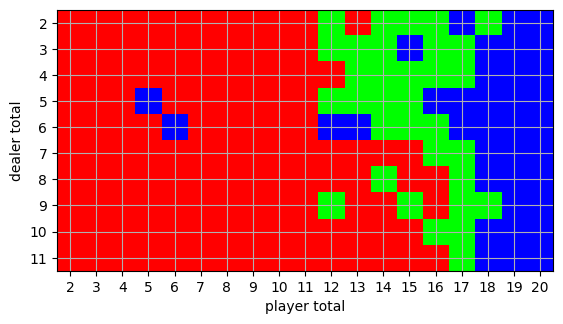

In [5]:
deck = CardDeck()
q_dict_player2 = dict()
print("Pretraining Player 2:")
policy2, q_dict_player2 = pre_train_player(deck, num_games=epochs_pretrain)

In [6]:
def get_init_state2(
    state: State | str | None,
    deck: CardDeck,
    common_card: Card | None,
    debug: bool = False,
) -> State:
    """Generate initial state."""
    if state is None:
        player_card = deck.draw()
        total, has_ace = update_total(0, False, player_card.value)
        if common_card is None:
            raise ValueError("Common card cannot be None")

        common_card_value = min(common_card.value.value, 10)
        if debug:
            print(f"Player initial hand: {player_card}, {common_card}")
        return State(total, has_ace, common_card_value)
    else:
        if isinstance(state, str):
            assert state == "random", f"Invalid init state specification: '{state}'"
            return random_state()
        else:
            return state

def get_init_states(deck: CardDeck, debug: bool = False) -> (State, State):
    # Draw the common card and print it
    common_card = deck.draw()

    # Initialize state for Player 1
    player1_state = get_init_state2(None, deck, common_card, debug)
    player1_state.total, player1_state.has_ace = update_total(
        player1_state.total, player1_state.has_ace, common_card.value
    )

    # Initialize state for Player 2
    player2_state = get_init_state2(None, deck, common_card, debug)
    player2_state.total, player2_state.has_ace = update_total(
        player2_state.total, player2_state.has_ace, common_card.value
    )
    return player1_state, player2_state

def compare_totals(player1_total, player2_total) -> int:
    # Check for busts
    player1_bust = player1_total is None or player1_total > 21
    player2_bust = player2_total is None or player2_total > 21

    # Both players bust
    if player1_bust and player2_bust:
        return 0  # Draw

    # Only Player 1 busts
    if player1_bust:
        return -1  # Player 2 wins

    # Only Player 2 busts
    if player2_bust:
        return 1  # Player 1 wins

    # Compare totals if no busts
    if player1_total > player2_total:
        return 1  # Player 1 wins
    elif player1_total < player2_total:
        return -1  # Player 2 wins
    else:
        return 0  # Draw
    
def play_game_2_players(
    policy1: Policy,
    policy2: Policy,
    deck: CardDeck,
    gamma: float = 1.0,
    game_report_callback: ReportCallback | None = None,
    player1_report_callback: ReportCallback | None = None,
    player2_report_callback: ReportCallback | None = None,
    debug: bool = False,
    player1_starts: bool = True,
) -> tuple[int, Experience]:
    report = lambda txt: game_report_callback and game_report_callback(txt)

    # Initialize states for both players
    player1_state, player2_state = get_init_states(deck, debug)

    if player1_starts:
        # Player 1 takes their turn first
        player1_total, player1_log = play_turn(
            policy1, deck, player1_state, report_callback=player1_report_callback
        )
        # Then Player 2 takes their turn
        player2_total, player2_log = play_turn(
            policy2, deck, player2_state, report_callback=player2_report_callback
        )
    else:
        # Player 2 takes their turn first if player1_starts is False
        player2_total, player2_log = play_turn(
            policy2, deck, player2_state, report_callback=player2_report_callback
        )
        # Then Player 1 takes their turn
        player1_total, player1_log = play_turn(
            policy1, deck, player1_state, report_callback=player1_report_callback
        )

    game_result = compare_totals(player1_total, player2_total)

    report(f"Game result: {game_result}")

    player1_experience = build_experience(player1_log, game_result, gamma)
    player2_experience = build_experience(player2_log, -game_result, gamma)  # Note the negative result for the second player

    return game_result, player1_experience, player2_experience

Hajde da simuliramo jednu partiju sa politikama koje su igraci naucili igrajuci protiv dilera.

In [7]:
p1 = 0
p2 = 0

In [8]:
# Igrac 1 igra prvi u prvoj rundi
game_result, player1_experience, player2_experience = play_game_2_players(policy1, policy2, deck)
if game_result == -1:
    print("Igrac 2 je pobedio.")
    p2 += 1
    p1 += -1
elif game_result == 1:
    print("Igrac 1 je pobedio.")
    p2 += -1
    p1 += 1
else:
    print("Draw")

print(player1_experience)
print(player2_experience)

# Igrac 2 igra prvi u drugoj rundi 
game_result, player1_experience, player2_experience = play_game_2_players(policy1, policy2, deck, player1_starts=False)
if game_result == -1:
    print("Igrac 2 je pobedio.")
    p2 += 1
    p1 += -1
elif game_result == 1:
    print("Igrac 1 je pobedio.")
    p2 += -1
    p1 += 1
else:
    print("Draw")

print(player1_experience)
print(player2_experience)

# Rezultat partije je zbir rezultata rundi za svakog igraca
print(p1, p2)

Draw

[((7, False, 4), HIT, 0.0), ((18, True, 4), HIT, 0.0), ((19, True, 4), HOLD, 0)]

[((6, False, 4), HIT, 0.0), ((9, False, 4), HIT, 0.0), ((19, False, 4), HOLD, 0)]

Igrac 1 je pobedio.

[((6, False, 3), HIT, 1.0), ((16, False, 3), HOLD, 1)]

[((13, False, 3), HOLD, -1)]

1 -1

Iz prilozenog iznad se moze zakljuciti da su jednako dobri i da svaki pobedjuje u oko 50% slucajeva. Pusticemo ih da se medjusobno treniraju.

100%|██████████| 100000/100000 [00:22<00:00, 4504.46it/s]


Konacni rezultat igraca 1:  -1234

Konacni rezultat igraca 2:  1234

Finalna Politika za Igraca 1:

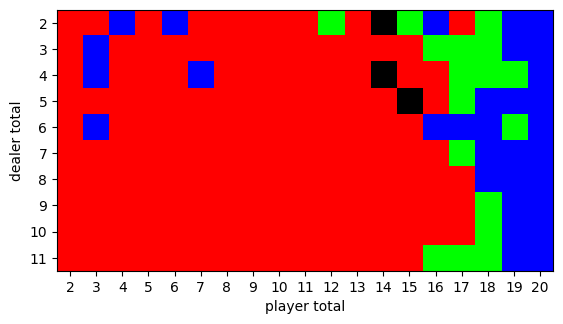

In [11]:
epochs=100000
p1 = 0
p2 = 0
p1_best = -float("inf")
p2_best = -float("inf")
q_dict_best_player1 = dict()
q_dict_best_player2 = dict()

for epoch in trange(epochs):
    player_1_starts = epoch % 2 == 0
    # Greedy politika za oba igraca
    policy_player1 = create_greedy_policy(q_dict_player1)
    policy_player2 = create_greedy_policy(q_dict_player2)

    # Igraj igre i apdejtuj politike
    game_result, exp_player1, exp_player2 = play_game_2_players(policy1, policy2, deck)
    if game_result == -1:    # Igrac 2 je pobedio
        p2 += 1
        p1 += -1
    elif game_result == 1:   # Igrac 1 je pobedio
        p2 += -1
        p1 += 1

    q_dict_player1 = update_Q(q_dict_player1, exp_player1, alpha=0.1)
    q_dict_player2 = update_Q(q_dict_player2, exp_player2, alpha=0.1)

    if p1>p1_best:
        p1_best = p1
        q_dict_best_player1 = deepcopy(q_dict_player1)
    if p2>p2_best:
        p2_best = p2
        q_dict_best_player2 = deepcopy(q_dict_player2)

final_policy_player1 = create_greedy_policy(q_dict_best_player1)
final_policy_player2 = create_greedy_policy(q_dict_best_player2)

print("Konacni rezultat igraca 1: ", p1)
print("Konacni rezultat igraca 2: ", p2)

print("Finalna Politika za Igraca 1:")
visualize_policy(final_policy_player1)

Visualizing Final Policy for Player 2:

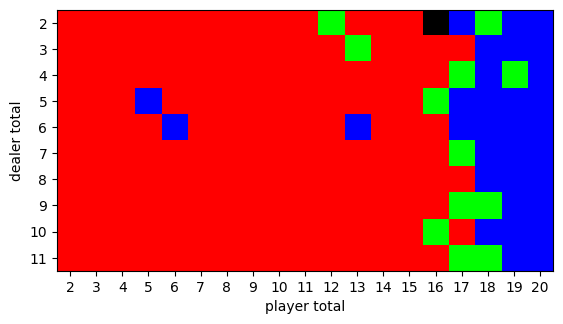

In [10]:
print("Finalna Politika za Igraca 2:")
visualize_policy(final_policy_player2)